In [5]:
%load_ext autoreload
%autoreload 2
import wandb

from wandb_utils import *

api = wandb.Api()
run = example_train_run(api)
run = RunWrapper(run)

manager = RunDataManager(Path('../run_data'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
run_1 = RunWrapper(api.run('romeu/NeRF2D/qyxltox2'))
run_2 = RunWrapper(api.run('romeu/NeRF2D/5x9fjp84'))

runs = [run_1, run_2]

100%|██████████| 1/1 [00:00<00:00, 430.67it/s]


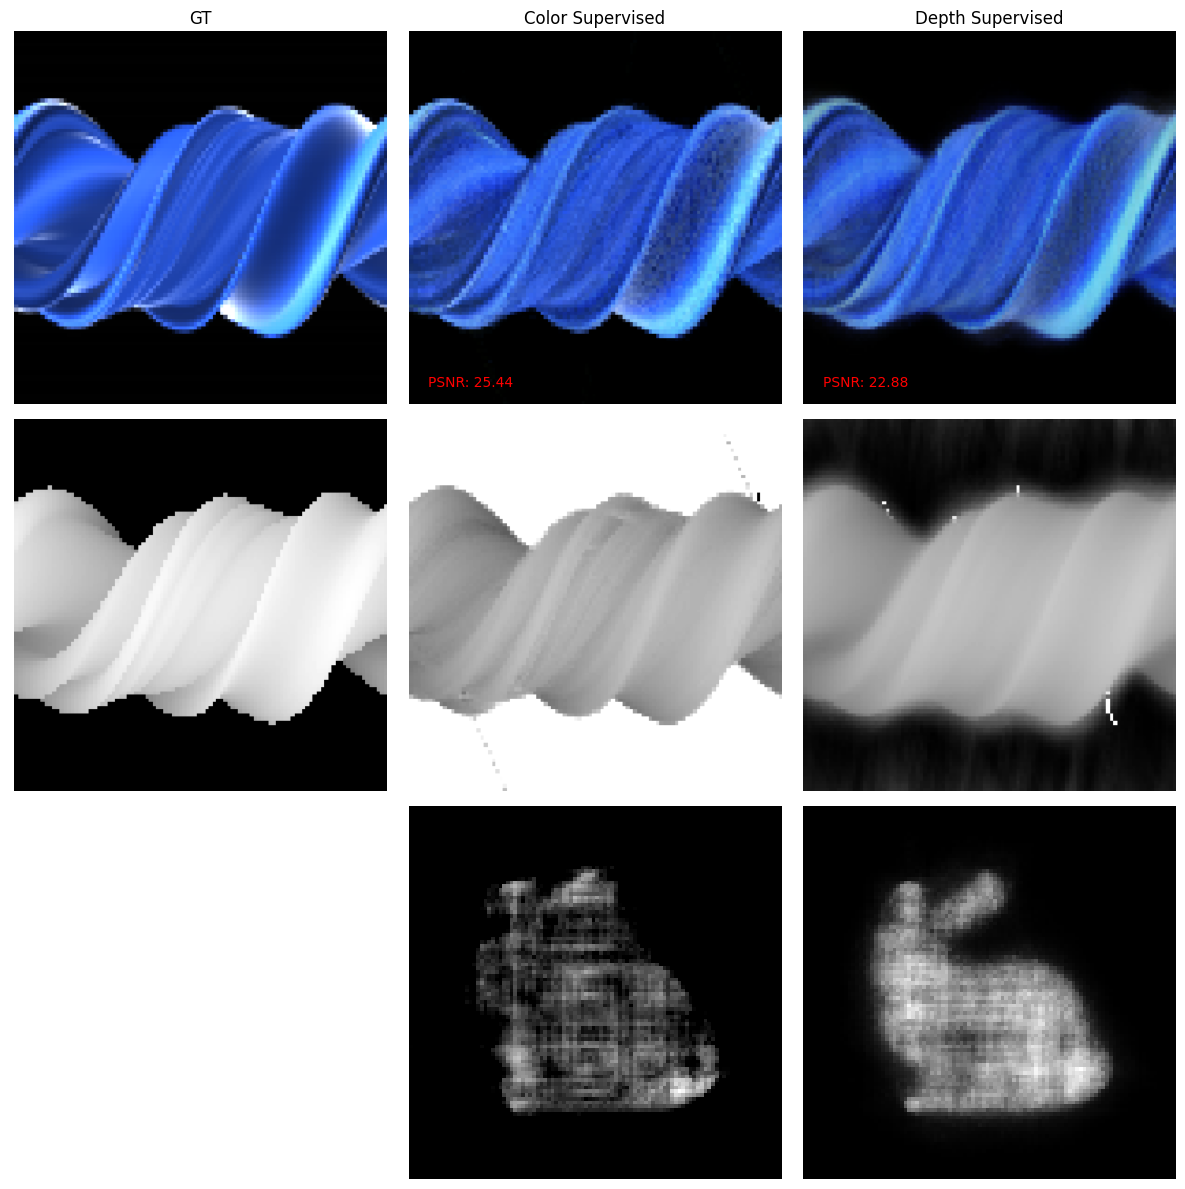

In [4]:
from visualizations.compare_runs import compare_runs

def title_fun(run):
    return 'Depth Supervised' if run.run.config["use_depth_supervision"] else 'Color Supervised'

compare_runs(
    runs,
    manager,
    with_gt=True,
    with_renders=True,
    with_depth=True,
    with_density=True,
    fig_scale=4,
    title_fun=title_fun
)

In [27]:
runs_all = api.runs('romeu/NeRF2D')
runs_tagged = [RunWrapper(run) for run in runs_all if 'n_freqs_exp' in run.tags]

100%|██████████| 1/1 [00:00<00:00, 1292.15it/s]


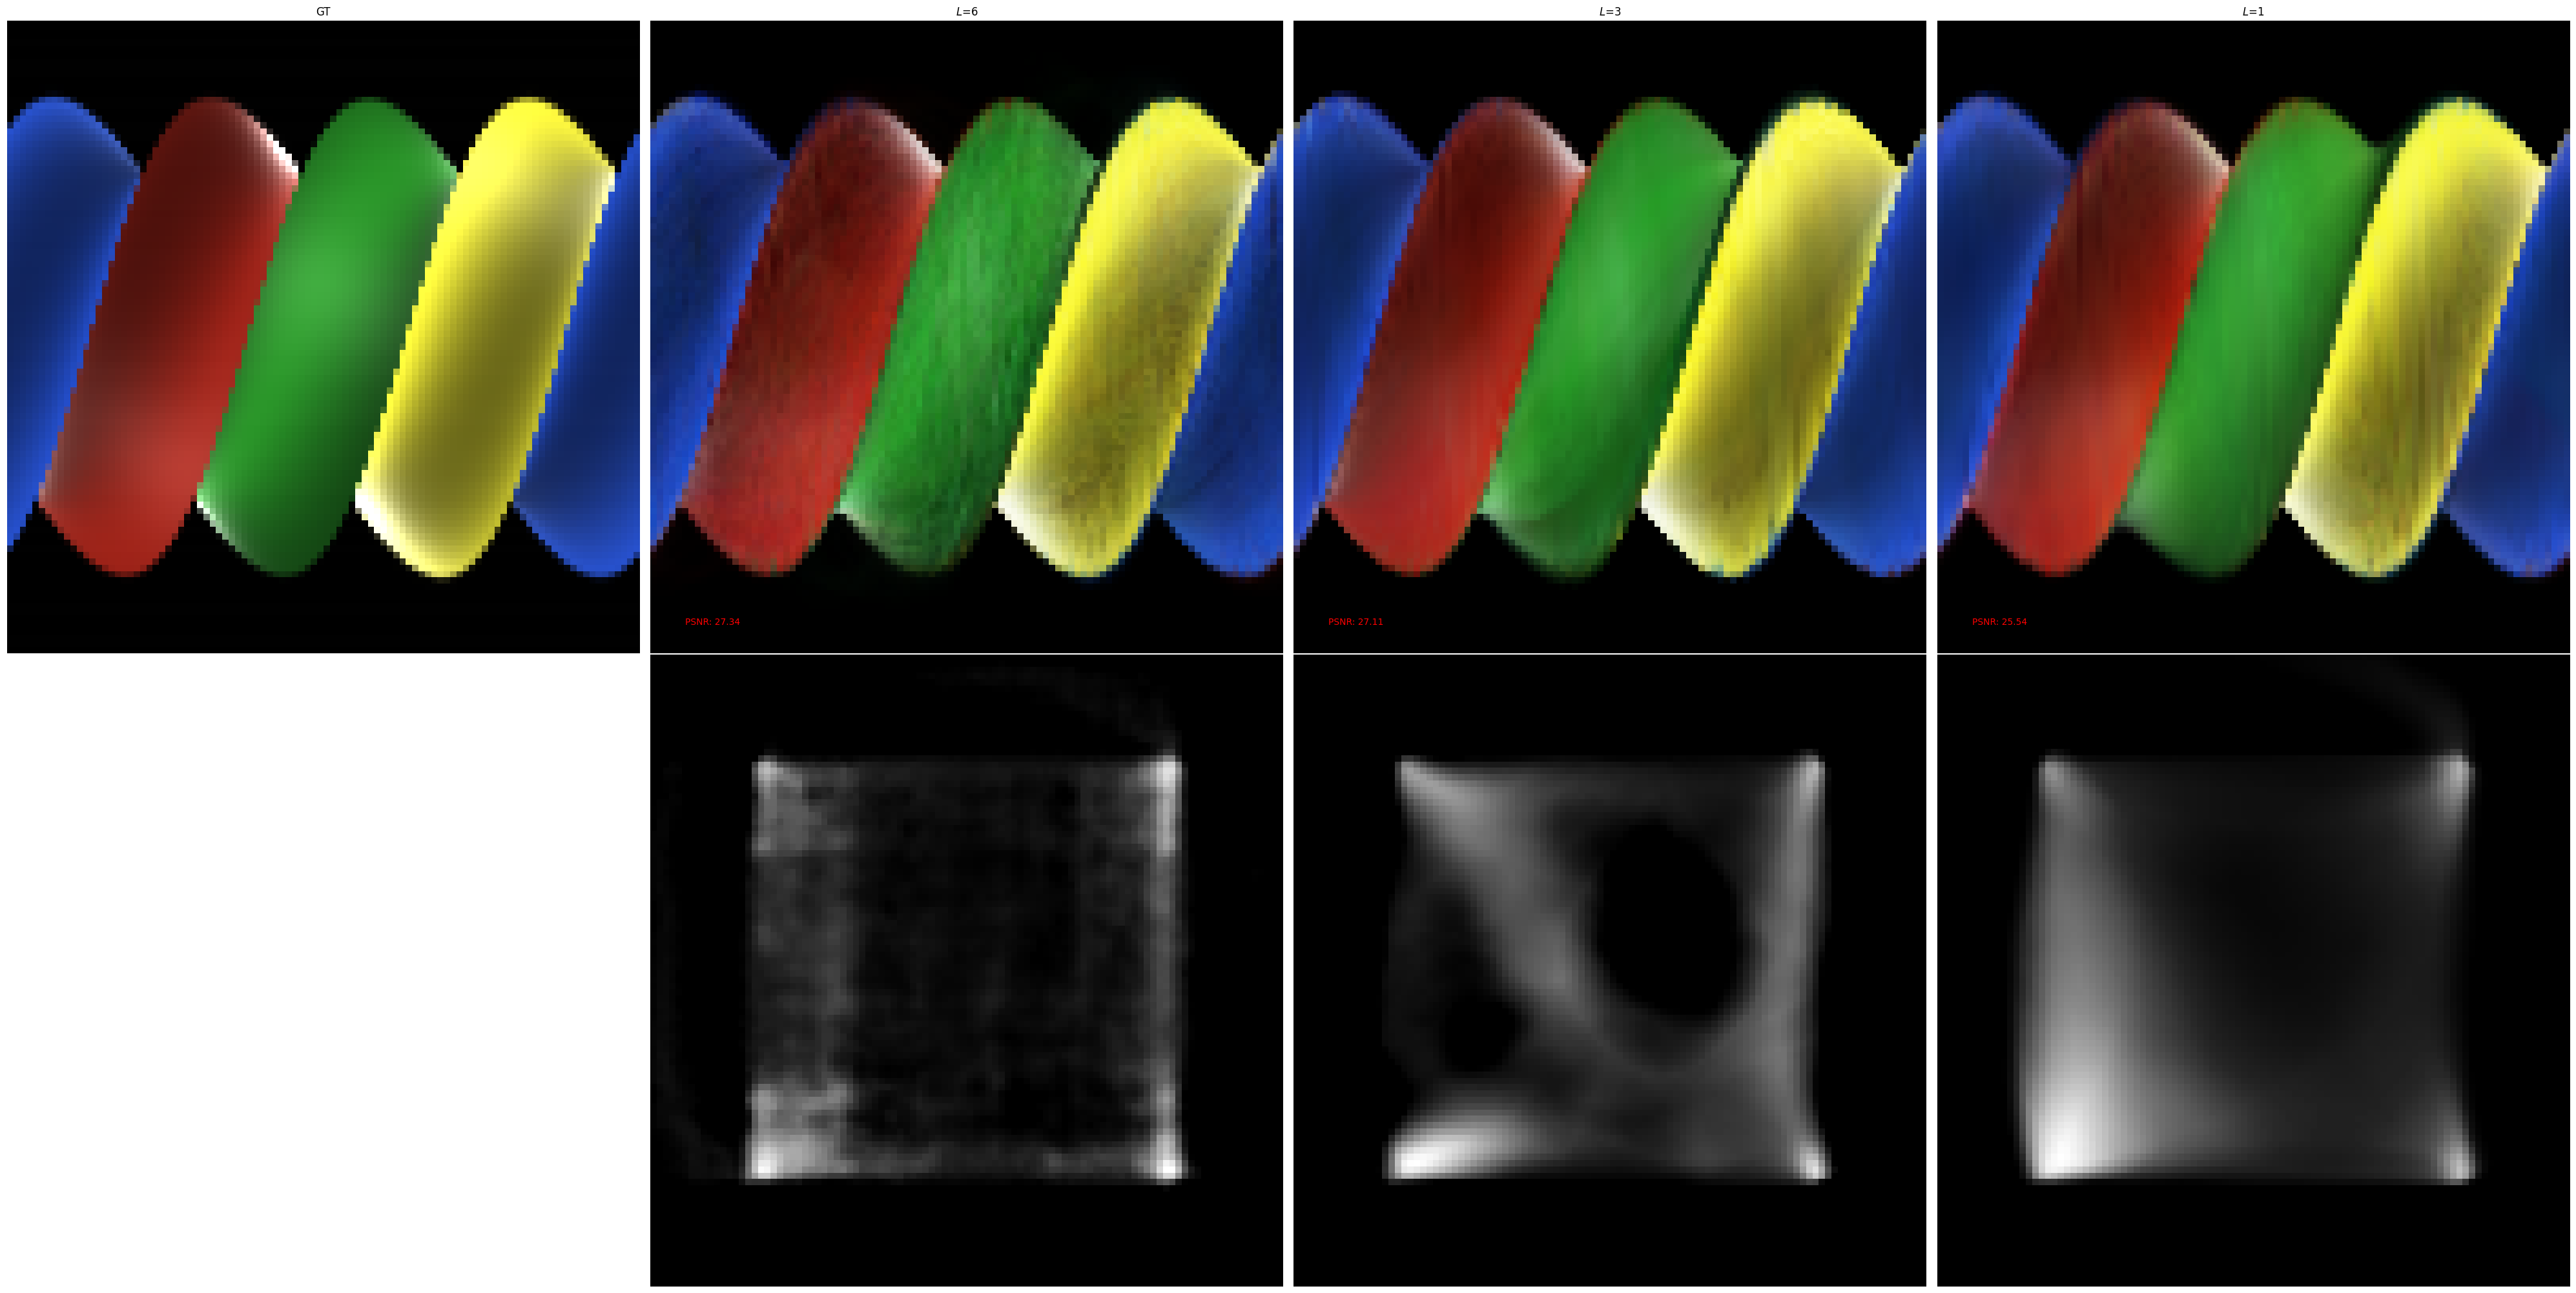

In [36]:
def title(run):
    return f'$L$={run.run.config["n_freqs_pos"]}'

compare_runs(
    runs_tagged,
    manager,
    with_gt=True,
    with_renders=True,
    with_depth=False,
    with_density=True,
    fig_scale=10,
    title_fun=title
)